In [14]:
import os
import sys
from typing import List, Tuple, Optional, Union
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import json
import yaml
from pathlib import Path
import rasterio
import random
from glob import glob

from util.datasets import SentinelIndividualImageDataset
from util.misc import load_model
from models_cae import cae_vit_base_patch16
from models_mae import mae_vit_base_patch16

device = torch.cuda.is_available() and 'cuda' or 'cpu'
device

'cuda'

# Get Samples

In [2]:
def load_satellite_images(image_dir: str, n_samples: int = 2, 
                         red_band: int = 4, green_band: int = 3, blue_band: int = 2) -> List[np.ndarray]:
    """
    Load RGB composites from satellite imagery TIFF files.
    
    Args:
        image_dir: Directory containing TIFF files
        n_samples: Number of random images to load
        red_band: Band number for red channel (1-based indexing)
        green_band: Band number for green channel
        blue_band: Band number for blue channel
    
    Returns:
        List of numpy arrays with shape (H, W, 3) containing normalized RGB images
    """
    # Get all tiff files in directory
    tiff_files = glob(os.path.join(image_dir, "*.tif"))
    
    if not tiff_files:
        raise ValueError(f"No TIFF files found in {image_dir}")
    
    # Randomly select n files
    selected_files = random.sample(tiff_files, min(n_samples, len(tiff_files)))
    
    images = []
    filenames = []
    
    red_band, green_band, blue_band = 4, 3, 2
    
    for file_path in selected_files:
        with rasterio.open(file_path) as src:
            # Read the specified bands (adjusting for 0-based indexing)
            r = src.read(red_band)
            g = src.read(green_band)
            b = src.read(blue_band)
            
            # Stack bands and normalize
            rgb = np.stack([r, g, b], axis=-1)
            rgb_norm = (rgb - rgb.min()) / (rgb.max() - rgb.min())
            
            images.append(rgb_norm)
            filenames.append(os.path.basename(file_path))
    
    return images, filenames

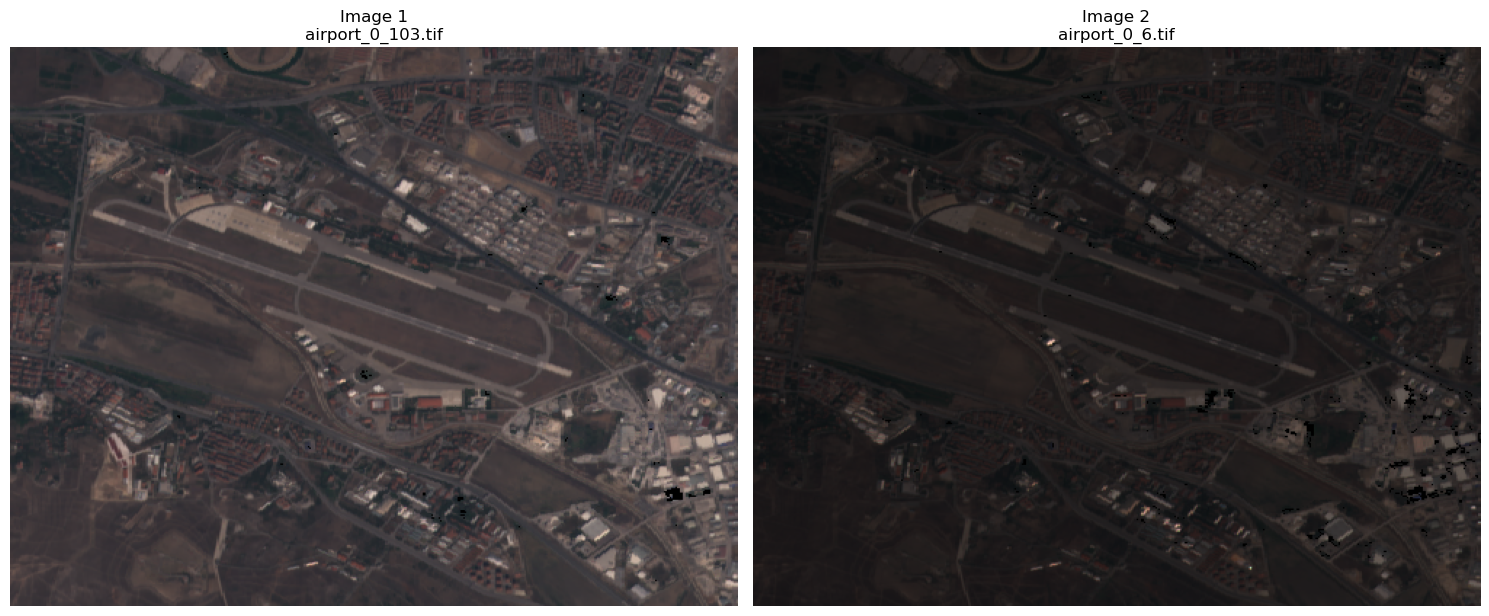

In [3]:
image_dir = "/home/ubuntu/satellite-cae/SatMAE/data/fmow-sentinel/train/airport/airport_0"

images, filenames = load_satellite_images(image_dir, n_samples=2)

fig, axes = plt.subplots(1, len(images), figsize=(15, 7))
if len(images) == 1:
    axes = [axes]

for idx, (img, fname) in enumerate(zip(images, filenames)):
    axes[idx].imshow(images[idx])
    axes[idx].set_title(f'Image {idx+1}\n{fname}')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [4]:
csv_path = "/home/ubuntu/satellite-cae/SatMAE/data/sampled_by_location.csv"

mean = SentinelIndividualImageDataset.mean
std = SentinelIndividualImageDataset.std
transform = SentinelIndividualImageDataset.build_transform(
    is_train=False, input_size=224, mean=mean, std=std
)
dataset = SentinelIndividualImageDataset(
    csv_path=csv_path,
    transform=transform
)

batch_size = 2
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

batch <class 'torch.Tensor'>
torch.Size([13, 224, 224])
torch.Size([13, 224, 224])


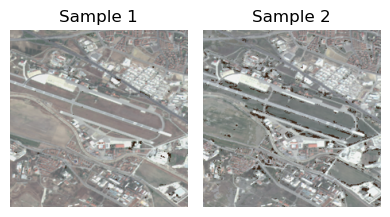

In [5]:
# Get one batch of samples
batch, _ = next(iter(dataloader))
print(f"batch {type(batch)}")

# Display the samples using bands 4,3,2 for RGB
fig, axes = plt.subplots(1, batch_size, figsize=(4, 4))
if batch_size == 1:
    axes = [axes]

for idx in range(batch_size):
    sample = batch[idx]  # Get individual sample from the list
    print(sample.shape)
    # The tensor has shape [1, 13, 224, 224], we need to squeeze out the first dimension
    sample = sample.squeeze(0)  # Now should be [13, 224, 224]
    
    # Extract bands 4,3,2 (indices 3,2,1 due to 0-based indexing)
    rgb = sample[[3,2,1]].numpy()  # Select bands
    rgb = np.transpose(rgb, (1, 2, 0))  # Change to (H, W, C) for plotting
    
    # Normalize for visualization
    rgb_norm = (rgb - rgb.min()) / (rgb.max() - rgb.min())
    
    axes[idx].imshow(rgb_norm)
    axes[idx].set_title(f'Sample {idx+1}')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Utils

In [6]:
def run_inference(model, dataloader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Run inference on the model and return reconstructions
    """
    model.eval()
    with torch.no_grad():
        # Get a batch of samples
        batch, _ = next(iter(dataloader))
        # Move samples to the same device as model
        batch = batch.to(device)
        
        # Run inference (we'll need to adjust this based on your model's forward method)
        loss, reconstructions, mask = model(batch)
        
        return batch, model.unpatchify(reconstructions, p=16, c=13)
    
def visualize_reconstruction(original, reconstruction, sample_idx=0):
    """
    Visualize the original and reconstructed images side by side
    Using bands 4,3,2 for RGB visualization
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Process original image
    orig_rgb = original[sample_idx].squeeze(0)[[3,2,1]].cpu().numpy()
    print(f"orig_rgb {orig_rgb.shape}")
    orig_rgb = np.transpose(orig_rgb, (1, 2, 0))
    orig_rgb = (orig_rgb - orig_rgb.min()) / (orig_rgb.max() - orig_rgb.min())
    
    # Process reconstructed image
    recon_rgb = reconstruction[sample_idx].squeeze(0)[[3,2,1]].cpu().numpy()
    print(f"recon_rgb {recon_rgb.shape}")
    recon_rgb = np.transpose(recon_rgb, (1, 2, 0))
    recon_rgb = (recon_rgb - recon_rgb.min()) / (recon_rgb.max() - recon_rgb.min())
    
    ax1.imshow(orig_rgb)
    ax1.set_title('Original')
    ax1.axis('off')
    
    ax2.imshow(recon_rgb)
    ax2.set_title('Reconstructed')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

# CAE

## Load Model

In [10]:
cae = cae_vit_base_patch16(in_chans=13)
cae.to(device)

checkpoint_path = "/home/ubuntu/satellite-cae/SatMAE/output_dir/checkpoint-0.pth"
checkpoint = torch.load(checkpoint_path, map_location='cpu')
cae.load_state_dict(checkpoint['model'], strict=False)

/tmp/ipykernel_2986/3891513390.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cpu')


<All keys matched successfully>

## Reconstruct

reconstructions shape torch.Size([2, 13, 224, 224])
orig_rgb (3, 224, 224)
recon_rgb (3, 224, 224)


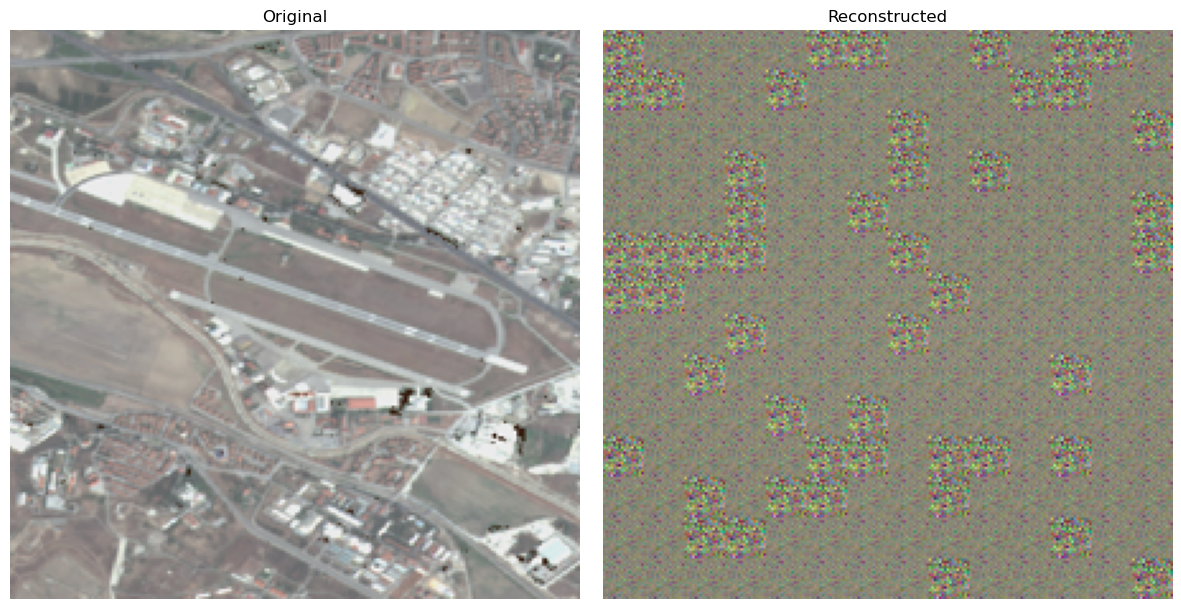

In [17]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

samples, reconstructions = run_inference(cae, dataloader, device)
print(f"reconstructions shape {reconstructions.shape}")
    
visualize_reconstruction(samples, reconstructions)

# MAE

In [15]:
mae = mae_vit_base_patch16(in_chans=13)
mae.to(device)

checkpoint_path = "/home/ubuntu/checkpoint-0.pth"
# checkpoint_path = "/home/ubuntu/satellite-cae/SatMAE/output_dir/checkpoint-0.pth"
checkpoint = torch.load(checkpoint_path, map_location='cpu')
mae.load_state_dict(checkpoint['model'], strict=False)

/tmp/ipykernel_2986/1184006763.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cpu')


<All keys matched successfully>

reconstructions shape torch.Size([2, 13, 224, 224])
orig_rgb (3, 224, 224)
recon_rgb (3, 224, 224)


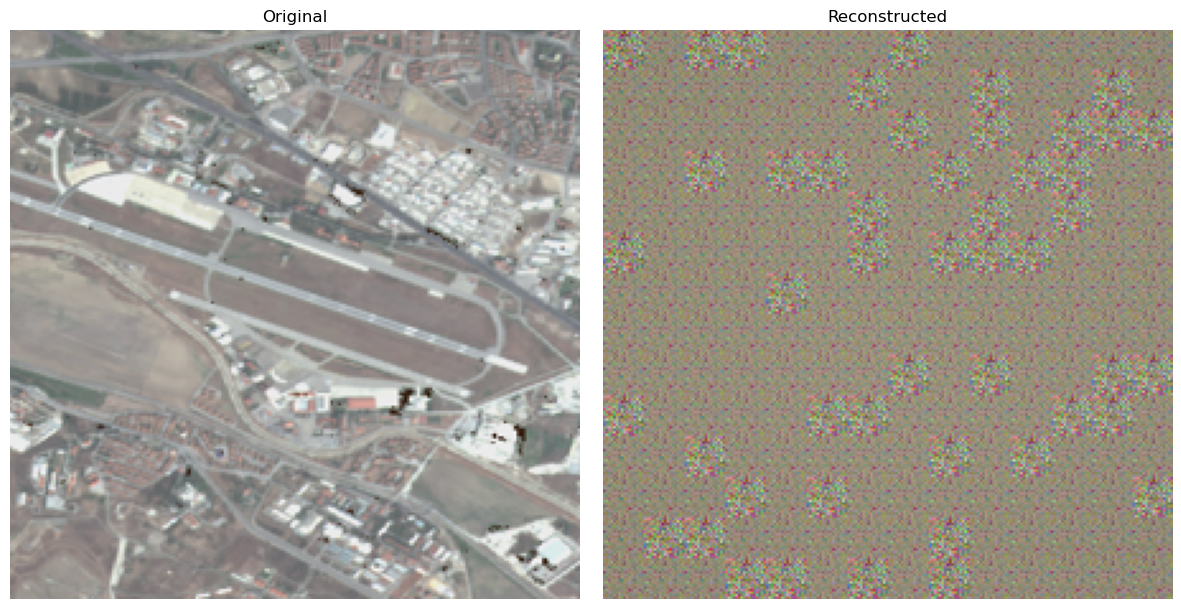

In [18]:
samples, reconstructions = run_inference(mae, dataloader, device)
print(f"reconstructions shape {reconstructions.shape}")

visualize_reconstruction(samples, reconstructions)